#  **Importing**  **Libraries**

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


#  **Text** **Tokenization**

In [ ]:
def tokenize(text):
    return text.lower().split()


# **Vocabulary** **Class** **Definition**

In [ ]:
class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]


# **SentimentDataset** **Class** **Definition**

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)


# **Padding**

In [ ]:
def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)


# **load** **glove** **Embeddings**

In [ ]:

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)


# **BiLSTM** **Model**

In [ ]:
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)


#**Evaluation**

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm


In [ ]:

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)


# **Training**

In [ ]:
def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


# **Confusion** **Matrix**

In [ ]:
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


# **Main** **Function**

Epoch 1: Loss = 35.7486, Train Acc = 0.5588, Dev Acc = 0.5441
Epoch 2: Loss = 30.7518, Train Acc = 0.6989, Dev Acc = 0.7598
Epoch 3: Loss = 22.0555, Train Acc = 0.8115, Dev Acc = 0.7843
Epoch 4: Loss = 15.7314, Train Acc = 0.8776, Dev Acc = 0.8162
Epoch 5: Loss = 9.6128, Train Acc = 0.9308, Dev Acc = 0.8186
Epoch 6: Loss = 5.7496, Train Acc = 0.9688, Dev Acc = 0.8162
Epoch 7: Loss = 3.6147, Train Acc = 0.9847, Dev Acc = 0.8113
Epoch 8: Loss = 2.3936, Train Acc = 0.9896, Dev Acc = 0.7990
Epoch 9: Loss = 1.6779, Train Acc = 0.9927, Dev Acc = 0.8064
Epoch 10: Loss = 0.8322, Train Acc = 0.9994, Dev Acc = 0.7941
Epoch 11: Loss = 0.4277, Train Acc = 0.9994, Dev Acc = 0.8015
Epoch 12: Loss = 0.2888, Train Acc = 1.0000, Dev Acc = 0.7966
Epoch 13: Loss = 0.2157, Train Acc = 1.0000, Dev Acc = 0.7966
Epoch 14: Loss = 0.1586, Train Acc = 1.0000, Dev Acc = 0.7990
Epoch 15: Loss = 0.1757, Train Acc = 1.0000, Dev Acc = 0.7966
Epoch 16: Loss = 0.1463, Train Acc = 1.0000, Dev Acc = 0.7917
Epoch 17: Los

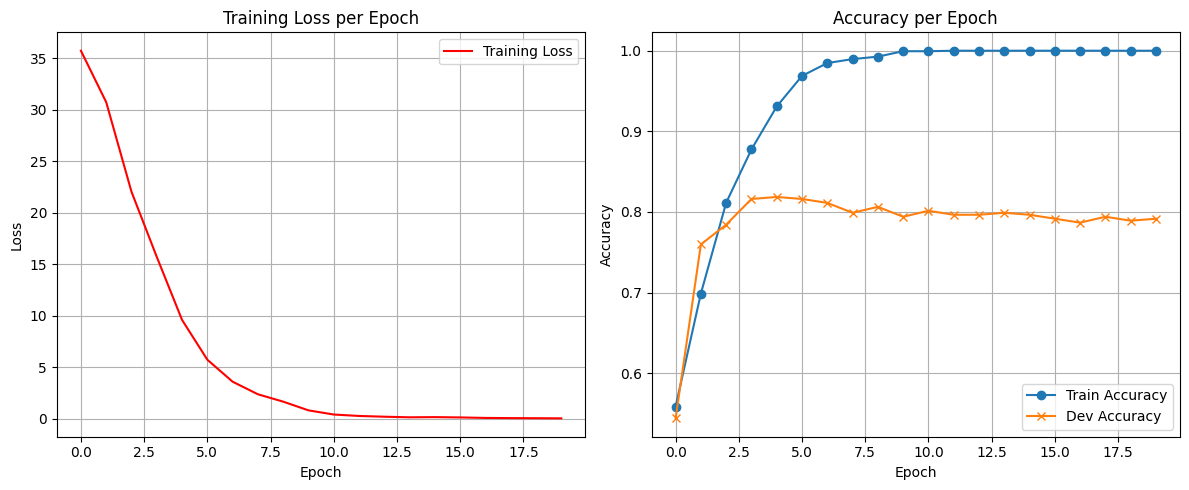


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.7902    0.7941    0.7922       204
           1     0.7931    0.7892    0.7912       204

    accuracy                         0.7917       408
   macro avg     0.7917    0.7917    0.7917       408
weighted avg     0.7917    0.7917    0.7917       408

Confusion Matrix:
 [[162  42]
 [ 43 161]]


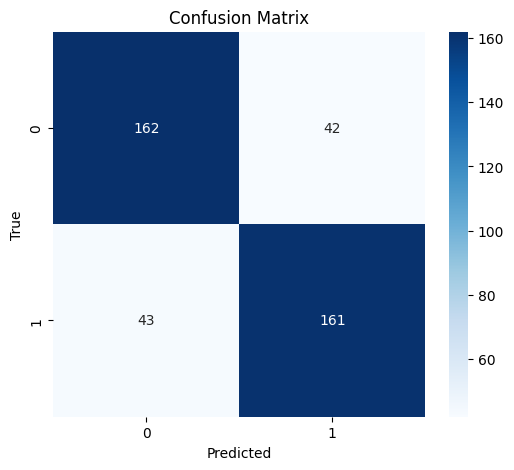


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7734    0.8006    0.7867       341
           1     0.7933    0.7654    0.7791       341

    accuracy                         0.7830       682
   macro avg     0.7833    0.7830    0.7829       682
weighted avg     0.7833    0.7830    0.7829       682

Confusion Matrix:
 [[273  68]
 [ 80 261]]


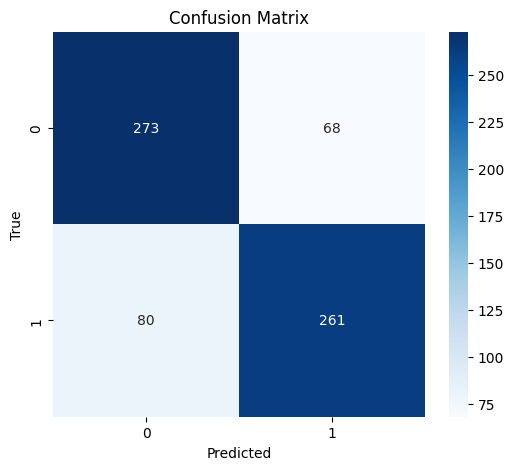

In [ ]:

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 1e-3
    epochs = 20
    dropout = 0
    use_bilstm = True
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                        embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


📊 Number of sentences per length range:
1-10: 859 sentences
11-20: 559 sentences
21-30: 171 sentences
31-40: 31 sentences
41-50: 5 sentences
51-60: 3 sentences
61-70: 0 sentences
71-80: 1 sentences
81-90: 0 sentences
91-100: 0 sentences
101-110: 0 sentences
111-120: 0 sentences
121-130: 0 sentences
131-140: 0 sentences
141-150: 0 sentences
151-160: 0 sentences
161-170: 0 sentences
171-180: 0 sentences
181-190: 0 sentences
191-200: 1 sentences
201-210: 0 sentences
211-220: 0 sentences
221-230: 0 sentences
231-240: 0 sentences
241-250: 0 sentences
251-260: 0 sentences
261-270: 0 sentences
271-280: 0 sentences
281-290: 0 sentences
291-300: 0 sentences
301-310: 1 sentences
311-320: 0 sentences
321-330: 0 sentences
331-340: 0 sentences
341-350: 0 sentences
351-360: 0 sentences
361-370: 0 sentences
371-380: 0 sentences
381-390: 0 sentences
391-400: 0 sentences
401-410: 0 sentences
411-420: 0 sentences
421-430: 0 sentences
431-440: 0 sentences
441-450: 0 sentences
451-460: 0 sentences
461-470

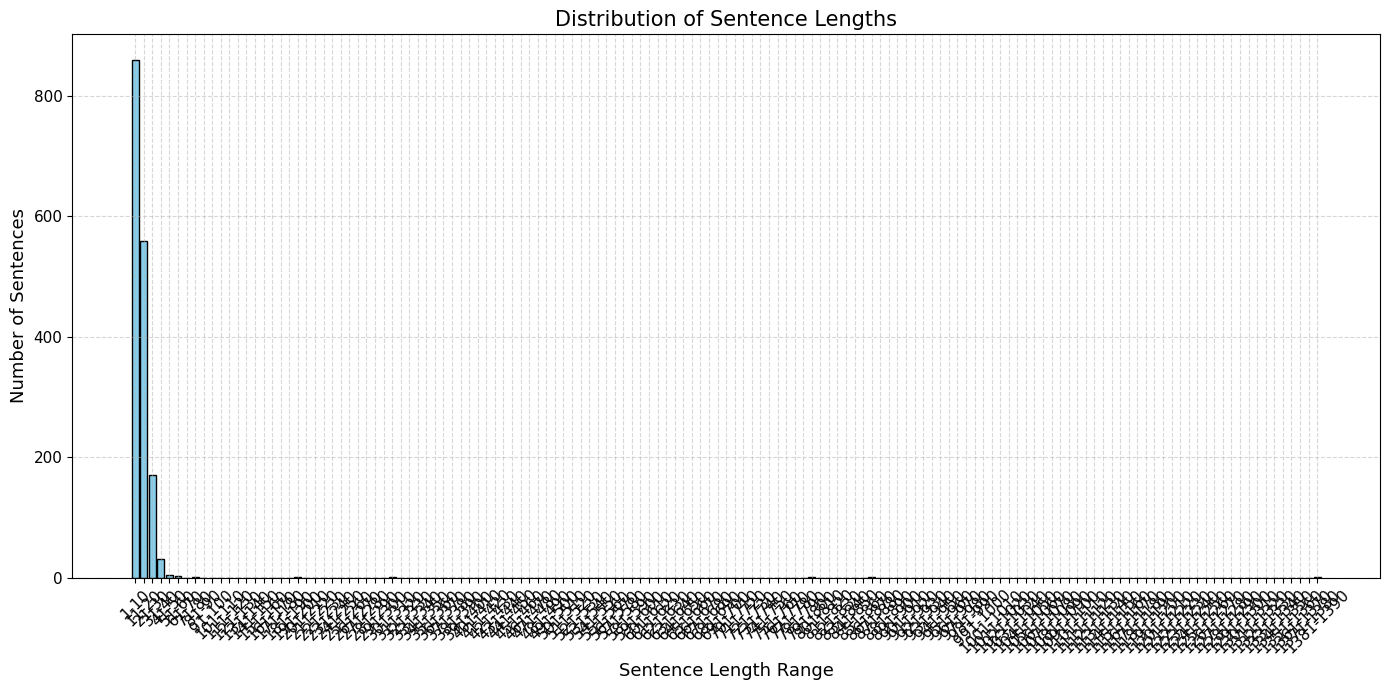

In [ ]:


def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word in word_freq:
            self.word2idx[word] = len(self.word2idx)

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

df = pd.read_csv("sentiment_train.csv")
sentences = df['sentence'].tolist()

vocab = Vocab(sentences)
encoded = [vocab.encode(sent) for sent in sentences]

lengths = [len(seq) for seq in encoded]
min_len = min(lengths)
max_len = max(lengths)
step = 10

range_counts = {}
for start in range(min_len, max_len + 1, step):
    end = start + step - 1
    count = sum(start <= length <= end for length in lengths)
    range_label = f"{start}-{end}"
    range_counts[range_label] = count

print("📊 Number of sentences per length range:")
for r, c in range_counts.items():
    print(f"{r}: {c} sentences")

plt.figure(figsize=(14, 7))
bars = plt.bar(range_counts.keys(), range_counts.values(), color='skyblue', edgecolor='black')
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel("Sentence Length Range", fontsize=13)
plt.ylabel("Number of Sentences", fontsize=13)
plt.title("Distribution of Sentence Lengths", fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)

for bar in bars:
    bar.set_width(0.8)

plt.tight_layout()
plt.show()
